<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3113, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 3113 (delta 147), reused 107 (delta 55), pack-reused 2868 (from 2)
Receiving objects: 100% (3113/3113), 76.49 MiB | 21.98 MiB/s, done.
Resolving deltas: 100% (2137/2137), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [178]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.lits import Lits, Stage2Dataset2D
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset_v1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image, resize_image
from kltn.processing.postprocessing import post_trans_stage1

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.04% complete (down: 16264.1 kB/s up: 493.1 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[17

## utils function

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
from matplotlib.colors import ListedColormap
import matplotlib
def visualize_ct_slice(ct_array, mask_array=None, axis=0, slice_index=None, alpha=0.4, cmap='gray', mask_cmap='tab10'):
    """
    Hiển thị 1 slice từ ảnh CT 3D (và overlay mask nếu có).

    Parameters:
    - ct_array: ndarray từ sitk.GetArrayFromImage (shape: [Z, Y, X])
    - mask_array: mask nhị phân cùng shape, có thể None
    - axis: trục cắt (0: axial, 1: coronal, 2: sagittal)
    - slice_index: chỉ số slice, nếu None sẽ lấy slice giữa
    - alpha: độ trong suốt của mask overlay
    - cmap: colormap cho ảnh CT
    """
    if slice_index is None:
        slice_index = ct_array.shape[axis] // 2

    if axis == 0:
        ct_slice = ct_array[slice_index, :, :]
        mask_slice = mask_array[slice_index, :, :] if mask_array is not None else None
    elif axis == 1:
        ct_slice = ct_array[:, slice_index, :]
        mask_slice = mask_array[:, slice_index, :] if mask_array is not None else None
    elif axis == 2:
        ct_slice = ct_array[:, :, slice_index]
        mask_slice = mask_array[:, :, slice_index] if mask_array is not None else None
    else:
        raise ValueError("Axis phải là 0, 1 hoặc 2.")

    plt.figure(figsize=(6, 6))
    plt.imshow(ct_slice, cmap=cmap)

    if mask_slice is not None:
        # Tạo colormap phân loại, bỏ màu background (label=0)
        if np.array_equal(np.unique(mask_slice), [0, 1, 2]):
          custom_colors = [
              [0, 0, 0, 0.0],           # label 0: transparent (black)
              [173/255, 216/255, 230/255, 1.0],  # label 1: light blue
              [1.0, 0, 0, 1.0],         # label 2: red
          ]
        else:
            custom_colors = [
              [0, 0, 0, 0.0],           # label 0: transparent (black)
              [173/255, 216/255, 230/255, 1.0],  # label 1: light blue
            ]

        custom_cmap = ListedColormap(custom_colors)
        plt.imshow(mask_slice, cmap=custom_cmap, alpha=alpha, interpolation='none')
    plt.title(f"Slice {slice_index} (axis={axis})")
    plt.axis('off')
    plt.show()


In [12]:
def find_best_slice(ct_array, mask_array=None, axis=0, threshold=0.01):
    """
    Tìm slice có nội dung nhiều nhất (ít background nhất) theo 1 trục.
    Nếu có mask: chọn slice có nhiều pixel mask nhất.

    Parameters:
    - ct_array: ndarray từ sitk.GetArrayFromImage
    - mask_array: ndarray mask hoặc None
    - axis: trục (0, 1, 2)
    - threshold: nếu không có mask, số pixel > ngưỡng coi là foreground

    Returns:
    - index của slice tốt nhất
    """
    if mask_array is not None:
        num_slices = mask_array.shape[axis]
        scores = []
        for i in range(num_slices):
            if axis == 0:
                mask = mask_array[i, :, :]
            elif axis == 1:
                mask = mask_array[:, i, :]
            elif axis == 2:
                mask = mask_array[:, :, i]
            scores.append(np.sum(mask))
    else:
        # Dùng CT để đánh giá slice "có thông tin"
        num_slices = ct_array.shape[axis]
        scores = []
        for i in range(num_slices):
            if axis == 0:
                sl = ct_array[i, :, :]
            elif axis == 1:
                sl = ct_array[:, i, :]
            elif axis == 2:
                sl = ct_array[:, :, i]
            scores.append(np.mean(np.abs(sl)) > threshold)

    best_index = int(np.argmax(scores))
    return best_index

In [54]:
def preprocessing_liver(image_ct, mask_liver):
  image, seg = Lits.preprocessing(image_ct, mask_liver, False, normalizations="zscores")
  seg = (seg > 0).astype(np.uint8)

  image, seg = image.astype(np.float32), seg.astype(np.uint8)
  image, seg = torch.from_numpy(image), torch.from_numpy(seg)

  return image, seg

In [171]:
path = "/content/LITS17/"
index = 16

## Visualize Liver

In [172]:
image = Lits.load_nii(f"{path}/volume-{index}.nii")
mask = Lits.load_nii(f"{path}/segmentation-{index}.nii")

In [173]:
best_slide = find_best_slice(image, mask)

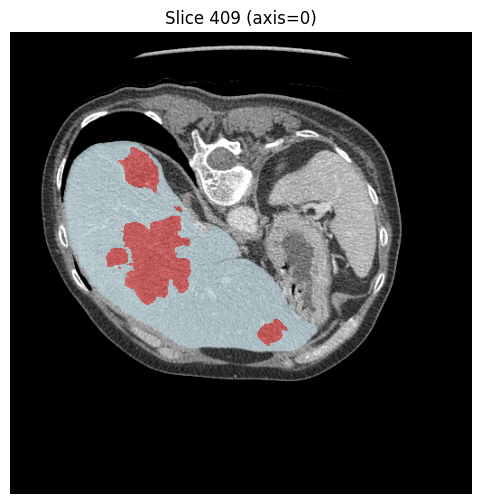

In [174]:
image = np.clip(image, -200, 250)
visualize_ct_slice(image, mask, slice_index=best_slide)

In [52]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/weight/best_metric_*liver*.pth"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSCoTNeXtUNet_liver_msa.pth']


In [55]:
weight_liver = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
model_liver = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)
model_liver.load_state_dict(torch.load(weight_liver))

<All keys matched successfully>

In [68]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image, mask)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

In [81]:
image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image.shape[0], image.shape[1], image.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()

In [86]:
mask = (mask > 0).astype(np.uint8)

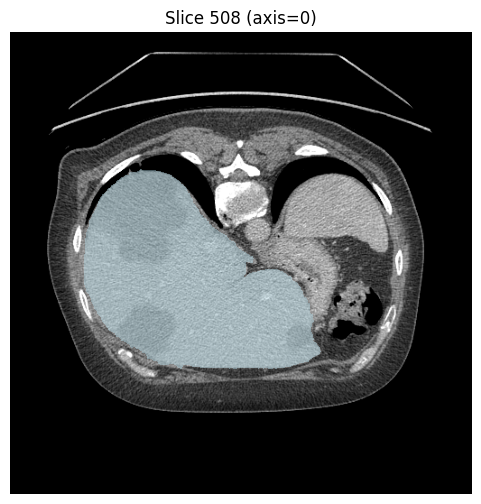

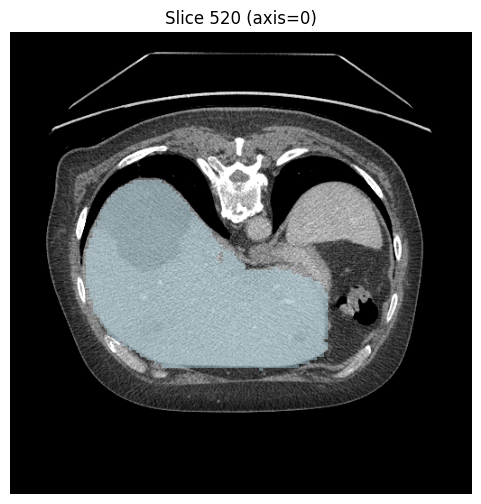

In [87]:
best_slide_pred = find_best_slice(image_liver, seg_liver)
visualize_ct_slice(image, mask, slice_index=best_slide)
visualize_ct_slice(image, seg_liver, slice_index=best_slide_pred)

In [175]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image, mask)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image.shape[0], image.shape[1], image.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()
mask = (mask > 0).astype(np.uint8)

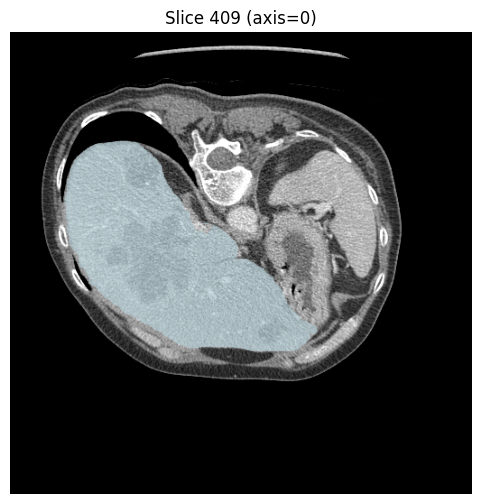

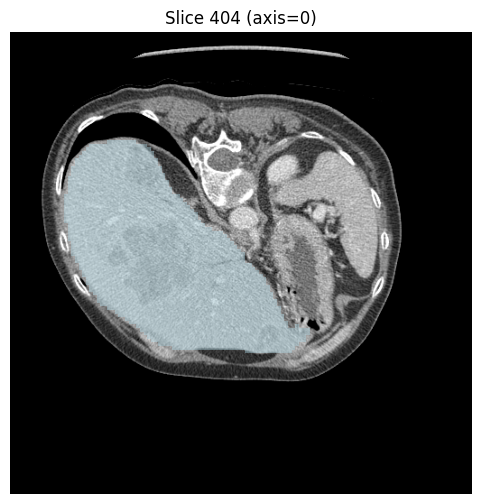

In [176]:
best_slide_pred = find_best_slice(image_liver, seg_liver)
visualize_ct_slice(image, mask, slice_index=best_slide)
visualize_ct_slice(image, seg_liver, slice_index=best_slide_pred)

## Visualize Tumor

In [179]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)

In [ ]:
convert_to_2D_dataset_v1(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

Patient 38 processed.
Patient 103 processed.
